# Univariate to Univariate Prediction
**This notebook compares the current LSTM model trained on emotion data against two naive models**:

1. Mean Model: Takes the mean of all timesteps in the lookback period.
2. Learnable Weighted Mean Model: Computes a weighted mean of all previous timesteps, where the weights are learned.



### For prediction, I will explore two approaches:
1. Recursive Single Prediction: Predicts future time steps one at a time using previous prediction as input for the next prediction.
2. All-Timestep Prediction: Predicts all future timesteps in one shot.

Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/Users/arnav/Google Drive/Cornell/Coding Projects/emili_TimeSeriesPredictor') #going up several files until emili_TimeSeriesPredictor
from time_series_predictor.Data.emotionFeatureExtractor import emotionFeatureExtractor
#Modeling imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.regularizers import l1, l2

### **Generating Synthetic Data**

**Parameters**

In [ ]:
delta_t = 0.1
lookback = 600
forecast = 300
stride = lookback + forecast #so no overlap

**Univariate synthetic data:**

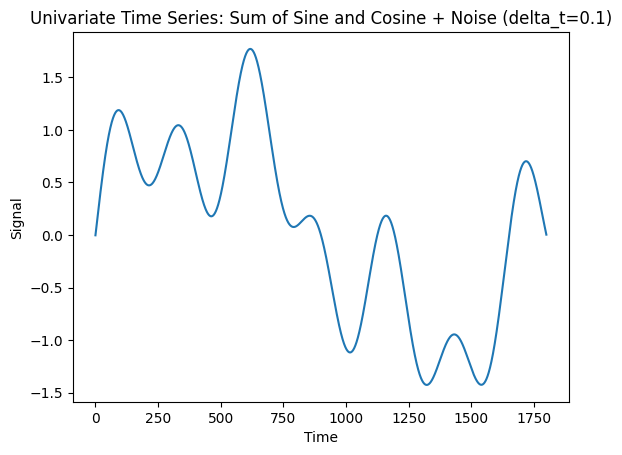

In [ ]:

def gen_univariate_synthetic_data(timesteps, delta_t, noise_level = 0.1):
    t = np.linspace(0, (timesteps-1)*delta_t, timesteps)

    signal = np.sin(2*np.pi/(0.1*timesteps)*t) + np.sin(10*np.pi/(0.1*timesteps)*t-5/(0.1*timesteps))*np.cos(10/(0.1*timesteps)*t)

    noise = np.random.normal(0, noise_level, timesteps)

    return t, signal + noise

t,univariate_data = gen_univariate_synthetic_data(timesteps = lookback*30, delta_t=delta_t, noise_level=0)

plt.plot(t, univariate_data)
plt.title(f"Univariate Time Series: Sum of Sine and Cosine + Noise (delta_t={delta_t})")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.show()

In [1]:

def train_test_split(data, lookback_period, forecast_period, stride, test_split = 0.2):
    # Ensure data is a numpy array
    data = np.array(data)

    # Initialize lists to hold the segmented data
    x, y = [], []

    # Loop over the dataset and create x and y using the sliding window approach
    for i in range(0, len(data) - lookback_period - forecast_period + 1, stride):
        x.append(data[i:i + lookback_period])
        y.append(data[i + lookback_period:i + lookback_period + forecast_period])

    # Convert lists to numpy arrays
    x = np.array(x)
    y = np.array(y)

    #creating new axis so data is (#samples, timesteps, features)
    if len(np.shape(x)) == 2:
        x = x[:,:,np.newaxis]
    if len(np.shape(y)) == 2:
        y = y[:,:,np.newaxis]

    # Determine the split point for the training and testing sets
    split_idx = int(np.shape(x)[0] * (1 - test_split))

    # Split the data into training and testing sets
    x_train, x_test = x[:split_idx], x[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return x_train, y_train, x_test, y_test


xTr,yTr,xTe,yTe = train_test_split(data = univariate_data, lookback_period = lookback, forecast_period = forecast, stride = stride)
print(xTr.shape) # (samples, length of sample = lookback)
print(xTe.shape)
print(yTr.shape) # (samples, length of forecast = forecast)
print(yTe.shape)

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 577, in _pydevd_bundle.pydevd_cython.PyDBFrame._handle_exception
  File "_pydevd_bundle/pydevd_cython.pyx", line 312, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/Users/arnav/Google Drive/Cornell/Coding Projects/emili_TimeSeriesPredictor/.venv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2070, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/Users/arnav/Google Drive/Cornell/Coding Projects/emili_TimeSeriesPredictor/.venv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2106, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


NameError: name 'univariate_data' is not defined

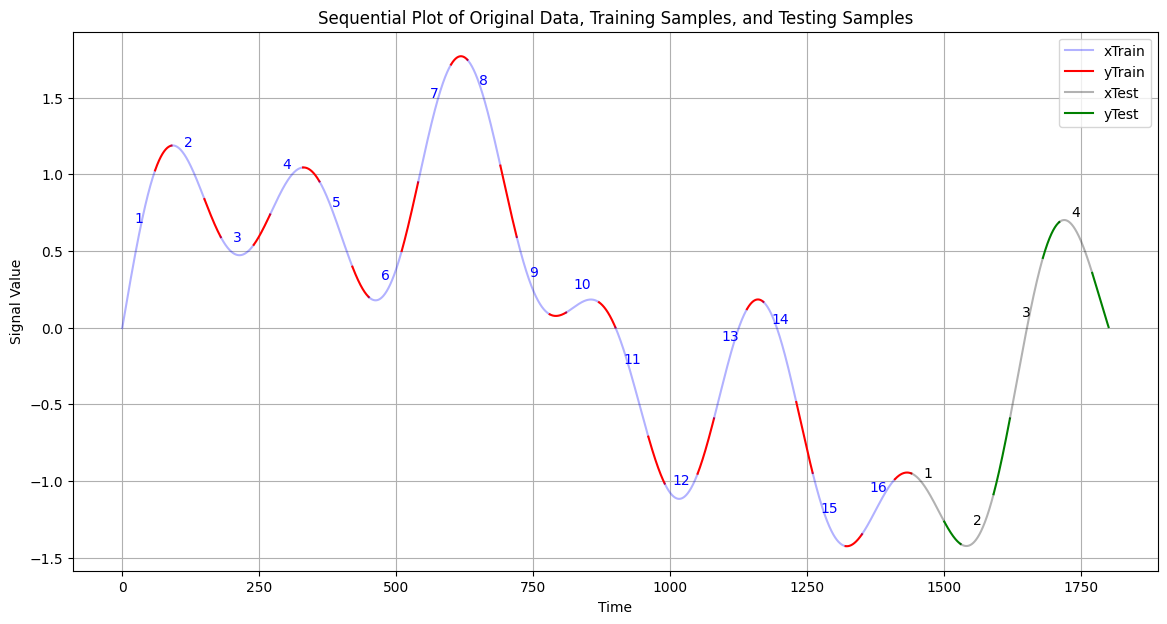

In [97]:
# plt.plot(univariate_data)
# plt.title(f"Univariate Time Series: Sum of Sine and Cosine + Noise (delta_t={delta_t})")
# plt.xlabel("Time")
# plt.ylabel("Signal")
# plt.show()

def plot_sequential_samples(univariate_data, x_train, y_train, x_test, y_test, delta_t):
    """
    Plots the original univariate data along with sequentially plotted x_train, y_train, x_test, and y_test.

    Parameters:
    - univariate_data: Original univariate time series data (1D array).
    - x_train: Training input data (2D array).
    - y_train: Training output data (2D array).
    - x_test: Testing input data (2D array).
    - y_test: Testing output data (2D array).
    - delta_t: The time interval between consecutive time steps.
    """
    plt.figure(figsize=(14, 7))

    # Plot original univariate data
    t_original = np.arange(len(univariate_data)) * delta_t
    # plt.plot(t_original, univariate_data, color='black', label='Original Data', linewidth=1.5)

    
    # Plot training data (x_train and y_train) sequentially
    lookback_period = x_train.shape[1]
    forecast_period = y_train.shape[1]
    start = 0
    for i in range(x_train.shape[0]):
        t_x_train = t_original[start:start + lookback_period]
        start += lookback_period
        t_y_train = t_original[start:start + forecast_period]
        start += forecast_period
        plt.plot(t_x_train, x_train[i], color='blue', alpha=0.3, linestyle='-', label='xTrain' if i == 0 else '')
        plt.annotate(f'{i+1}', (t_x_train[lookback_period//2], x_train[i, lookback_period//2]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
        plt.plot(t_y_train, y_train[i], color='red', linestyle='-', label='yTrain' if i == 0 else '')
        # plt.annotate(f'{i+1}', (t_y_train[0], y_train[i, 0]), textcoords="offset points", xytext=(0,10), ha='center', color='red')


    # Plot testing data (x_test and y_test) sequentially
    for i in range(x_test.shape[0]):
        t_x_test = t_original[start:start + lookback_period]
        start += lookback_period
        t_y_test = t_original[start:start + forecast_period]
        start += forecast_period
        plt.plot(t_x_test, x_test[i], color='black', alpha=0.3, linestyle='-', label='xTest' if i == 0 else '')
        plt.annotate(f'{i+1}', (t_x_test[lookback_period//2], x_test[i, lookback_period//2]), textcoords="offset points", xytext=(0,10), ha='center', color='black')
        plt.plot(t_y_test, y_test[i], color='green', linestyle='-', label='yTest' if i == 0 else '')

    plt.title("Sequential Plot of Original Data, Training Samples, and Testing Samples")
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Example usage (assuming xTr, yTr, xTe, and yTe are defined)
plot_sequential_samples(univariate_data, xTr, yTr, xTe, yTe, delta_t)

In [ ]:
#this model requires no training
def average_model(series):
    return np.average()

Now I create the weighted average model with learnable weights

In [ ]:
def time_weighted_sum_model(input_shape):
    """
    Create a model that applies a learnable weight to each timestep's 7-dimensional vector,
    then sums these weighted vectors element-wise across all timesteps.

    Parameters:
    input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
    model (tf.keras.Model): Compiled Keras model.
    """

    # Input layer for time series data (batch_size, 600, 7)
    input_layer = Input(shape=input_shape)  # Shape: (batch_size, 600, 7)

    # Dense layer to generate learnable weights for each timestep
    time_step_weights = Dense(1, activation=None)(input_layer)  # Shape: (batch_size, 600, 1)

    # Multiply the learnable scalar weights with the corresponding 7-dimensional vectors
    weighted_time_steps = Multiply()([input_layer, time_step_weights])  # Shape: (batch_size, 600, 7)

    # Sum the weighted vectors element-wise across the time dimension (axis=1)
    output = Lambda(lambda x: tf.reduce_sum(x, axis=1))(weighted_time_steps)  # Shape: (batch_size, 7)

    # Build and compile the model
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model